In [19]:
import math

from ProjectTools import OpenBeds

In [22]:
dry = True

def filterDepth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*math.sqrt(average))]
    # df = df.loc[df["readCount"] == 15] # Testing constant readcount

    return df

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))
    
    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))


In [26]:
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import numpy as np

def mergeModDFs(mod_df1, mod_df2):
    on_list = ["chromosome", "chromStart", "chromEnd", "modification_type"]
    redundant_cols = ["method", "readCount"]

    if mod_df1["method"].str.contains("Nanopore").all() == True:
        suffixes = ["_Nano", "_BS" ]
    else:
        suffixes = ["_BS", "_Nano"]

    merged = pd.merge(mod_df1.drop(columns=redundant_cols), 
                      mod_df2.drop(columns=redundant_cols), 
                      "inner", on_list, suffixes=suffixes).reset_index(drop=True)
    
    return merged

def binBenchmark(merged_df):
    merged_df["BS_bin"] = pd.cut(merged_df["percentMeth_BS"], 20)
    return merged_df

def makeLineplot(merged_df_wBSbin):
    return pd.DataFrame(merged_df_wBSbin.groupby("BS_bin").median(numeric_only=True)["percentMeth_Nano"])

def linePlotWrapper(merged_df):
    filtered_and_merged_wBSbin_df = binBenchmark(merged_df)
    return makeLineplot(filtered_and_merged_wBSbin_df)

def ROCbinariser(merged_df, threshold):
    binariser = preprocessing.Binarizer(threshold=threshold)
    merged_df["binarised"] = binariser.fit_transform(np.reshape(merged_df["percentMeth_BS"].to_numpy(), (-1, 1)))
    return merged_df

def makeROC(binarised_df):
    fpr, tpr, threshold = metrics.roc_curve(binarised_df["binarised"], binarised_df["percentMeth_Nano"])
    return fpr, tpr

def ROCwrapper(merged_df, threshold):
    binarised_df = ROCbinariser(merged_df, threshold)
    return makeROC(binarised_df)

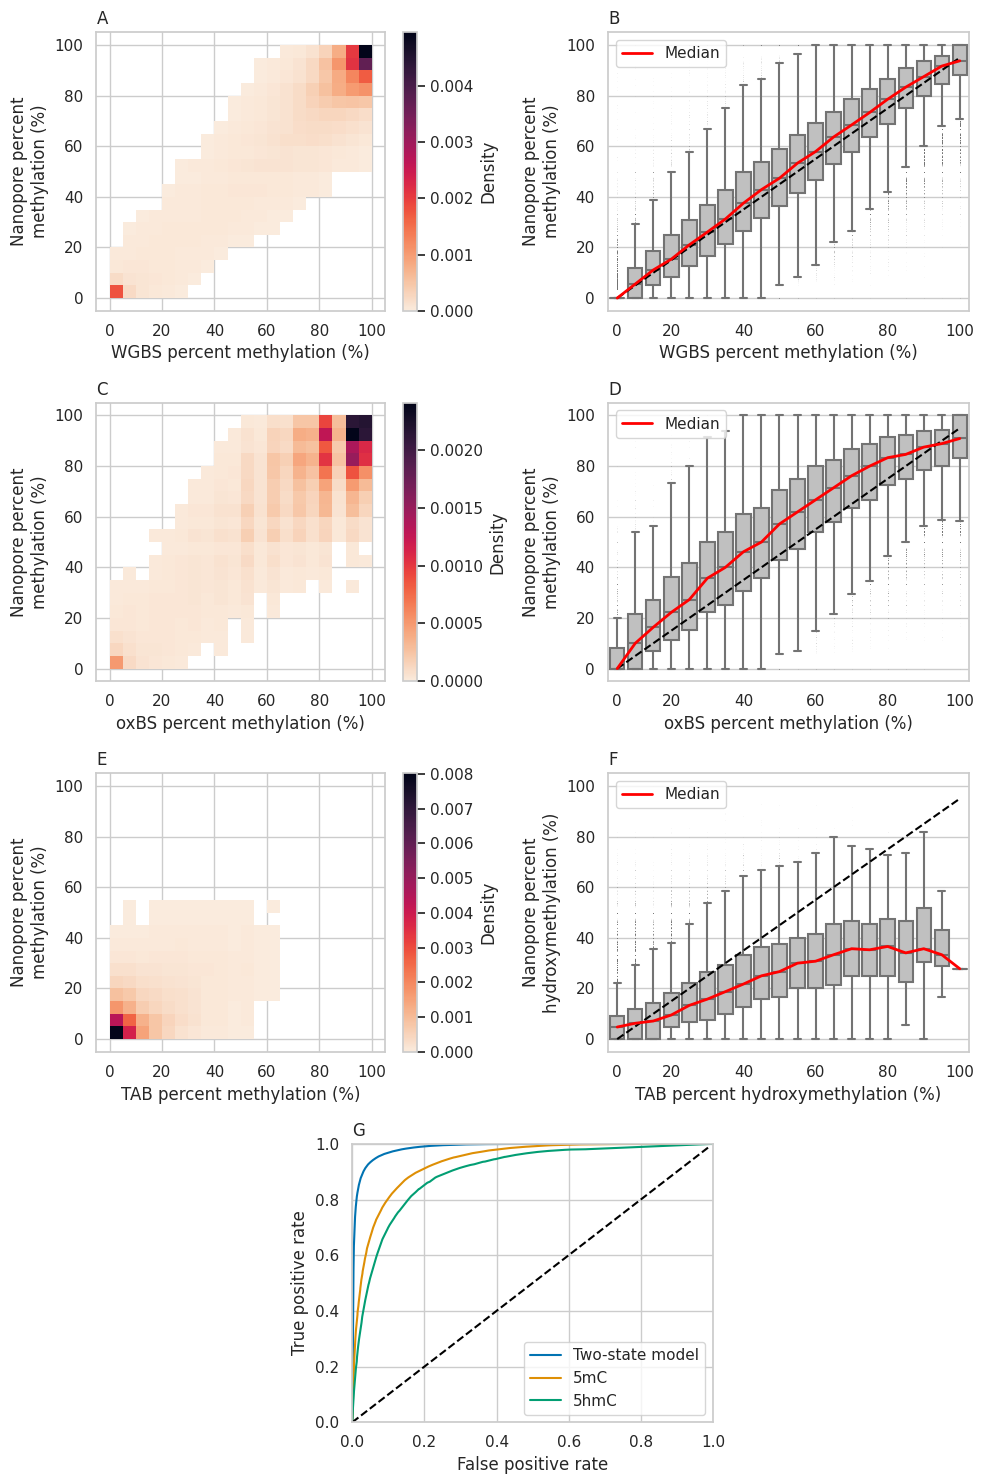

In [28]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as pl
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig1 = pl.figure(figsize=(10, 15)) 
gs1 = GridSpec(4, 4, fig1)

ax1 = fig1.add_subplot(gs1[0, :2])
ax2 = fig1.add_subplot(gs1[0, 2:])
ax3 = fig1.add_subplot(gs1[1, :2])
ax4 = fig1.add_subplot(gs1[1, 2:])
ax5 = fig1.add_subplot(gs1[2, :2])
ax6 = fig1.add_subplot(gs1[2, 2:])

merged_2mod_df = mergeModDFs(nano_2mod_df, wgbs_df)

sns.histplot(merged_2mod_df, x="percentMeth_BS", y="percentMeth_Nano", cmap="rocket_r", bins=20, pthresh=0.01, cbar=True, stat="density", ax=ax1, cbar_kws=dict(label="Density"))
ax1.set_xlabel("WGBS percent methylation (%)")
ax1.set_ylabel("Nanopore percent\nmethylation (%)")
ax1.set_title("A", loc="left")

sns.boxplot(binBenchmark(merged_2mod_df), x="BS_bin", y="percentMeth_Nano", color="silver", fliersize=0.01, flierprops={"marker":"x"}, ax=ax2)
ax2.plot(np.arange(0, 20, 1), np.arange(0, 100, 5), linestyle="dashed", color="black", zorder=5)
ax2.set_xticks([0, 3, 7, 11, 15, 19], labels=["0", "20", "40", "60", "80", "100"])
ax2.set_xlabel("WGBS percent methylation (%)")
ax2.set_ylabel("Nanopore percent\nmethylation (%)")
ax2.plot(np.arange(0, 20, 1), linePlotWrapper(merged_2mod_df)["percentMeth_Nano"], color="red", linewidth=2, label="Median", zorder=10)
ax2.legend()
ax2.set_title("B", loc="left")
sns.move_legend(ax2, "upper left")

merged_mc_df = mergeModDFs(nano_mc_df, oxbs_df)
sns.histplot(merged_mc_df, x="percentMeth_BS", y="percentMeth_Nano", cmap="rocket_r", bins=20, pthresh=0.01, cbar=True, stat="density", ax=ax3, cbar_kws=dict(label="Density"))
ax3.set_xlabel("oxBS percent methylation (%)")
ax3.set_ylabel("Nanopore percent\nmethylation (%)")
ax3.set_title("C", loc="left")

sns.boxplot(binBenchmark(merged_mc_df), x="BS_bin", y="percentMeth_Nano", color="silver", fliersize=0.01, flierprops={"marker":"x"}, ax=ax4)
ax4.plot(np.arange(0, 20, 1), np.arange(0, 100, 5), linestyle="dashed", color="black", zorder=5)
ax4.set_xticks([0, 3, 7, 11, 15, 19], labels=["0", "20", "40", "60", "80", "100"])
ax4.set_xlabel("oxBS percent methylation (%)")
ax4.set_ylabel("Nanopore percent\nmethylation (%)")
ax4.plot(np.arange(0, 20, 1), linePlotWrapper(merged_mc_df)["percentMeth_Nano"], color="red", linewidth=2, label="Median", zorder=10)
ax4.legend()
ax4.set_title("D", loc="left")
sns.move_legend(ax4, "upper left")

merged_hmc_df = mergeModDFs(nano_hmc_df, tab_df)
sns.histplot(merged_hmc_df, x="percentMeth_BS", y="percentMeth_Nano", cmap="rocket_r", bins=20, pthresh=0.01, cbar=True, stat="density", ax=ax5, cbar_kws=dict(label="Density"))
ax5.set_xlabel("TAB percent methylation (%)")
ax5.set_ylabel("Nanopore percent\nmethylation (%)")
ax5.set_title("E", loc="left")

sns.boxplot(binBenchmark(merged_hmc_df), x="BS_bin", y="percentMeth_Nano", color="silver", fliersize=0.01, flierprops={"marker":"x"}, ax=ax6)
ax6.plot(np.arange(0, 20, 1), np.arange(0, 100, 5), linestyle="dashed", color="black", zorder=5)
ax6.set_xticks([0, 3, 7, 11, 15, 19], labels=["0", "20", "40", "60", "80", "100"])
ax6.set_xlabel("TAB percent hydroxymethylation (%)")
ax6.set_ylabel("Nanopore percent\nhydroxymethylation (%)")
ax6.plot(np.arange(0, 20, 1), linePlotWrapper(merged_hmc_df)["percentMeth_Nano"], color="red", linewidth=2, label="Median", zorder=10)
ax6.legend()
ax6.set_title("F", loc="left")
sns.move_legend(ax6, "upper left")

ax7 = fig1.add_subplot(gs1[3, 1:3])
ax7.plot(ROCwrapper(merged_2mod_df, threshold=50)[0], ROCwrapper(merged_2mod_df, threshold=50)[1], '-', label="Two-state model")
ax7.plot(ROCwrapper(merged_mc_df, threshold=50)[0], ROCwrapper(merged_mc_df, threshold=50)[1], '-', label="5mC")
ax7.plot(ROCwrapper(merged_hmc_df, threshold=50)[0], ROCwrapper(merged_hmc_df, threshold=50)[1], '-', label="5hmC")
ax7.set_xlabel("False positive rate")
ax7.set_ylabel("True positive rate")
ax7.set_xlim(0, 1)
ax7.set_ylim(0, 1)
ax7.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), "black", linestyle="--")
ax7.legend()
ax7.set_title("G", loc="left")

fig1.tight_layout()

In [56]:
# How about a confusion matrix? 

threeMod_nano_df = pd.merge(
    nano_mc_df.drop(columns=["method", "readCount", "modification_type"]), 
    nano_hmc_df.drop(columns=["method", "readCount", "modification_type"]), 
    "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_5mC_Test", "_5hmC_Test"]
                          )

threeMod_bench_df = pd.merge(
    oxbs_df.drop(columns=["method", "readCount", "modification_type"]), 
    tab_df.drop(columns=["method", "readCount", "modification_type"]), 
    "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_5mC_Truth", "_5hmC_Truth"]
                          )
merged_threeMod_bench_df = pd.merge(threeMod_nano_df, threeMod_bench_df, "inner", ["chromosome", "chromStart", "chromEnd"])

mad_5mc = np.mean(abs(np.subtract(merged_threeMod_bench_df["percentMeth_5mC_Truth"], merged_threeMod_bench_df["percentMeth_5mC_Test"])))
mad_5hmc = np.mean(abs(np.subtract(merged_threeMod_bench_df["percentMeth_5hmC_Truth"], merged_threeMod_bench_df["percentMeth_5hmC_Test"])))
mad_5mc, mad_5hmc

(11.87805158370822, 7.908496278464032)

In [40]:
len(merged_3mod_bench_df)

136785

In [12]:
two_mod_binariser = preprocessing.Binarizer(threshold=50.0)

three_mod_binariser = preprocessing.Binarizer(threshold=50.0)

In [8]:
from scipy import stats

stats.mannwhitneyu(merged_2mod_df["percentMeth_Nano"], merged_2mod_df["percentMeth_BS"])

MannwhitneyuResult(statistic=478029907199272.5, pvalue=0.0)

In [9]:
stats.mannwhitneyu(merged_hmc_df["percentMeth_Nano"], merged_hmc_df["percentMeth_BS"])

MannwhitneyuResult(statistic=82508668217650.5, pvalue=1.4491828344391362e-08)

In [10]:
merged_hmc_df["percentMeth_Nano"].median()

7.140000000000001

In [11]:
merged_hmc_df["percentMeth_BS"].median()

7.14285714285714

In [12]:

stats.pearsonr(merged_2mod_df["percentMeth_Nano"], merged_2mod_df["percentMeth_BS"])

PearsonRResult(statistic=0.9267642146866754, pvalue=0.0)

In [13]:
stats.pearsonr(merged_hmc_df["percentMeth_Nano"], merged_hmc_df["percentMeth_BS"])

PearsonRResult(statistic=0.5218785588966226, pvalue=0.0)

In [14]:
stats.spearmanr(merged_2mod_df["percentMeth_Nano"], merged_2mod_df["percentMeth_BS"])

SignificanceResult(statistic=0.767759363643011, pvalue=0.0)

In [15]:
pm, rm, fm, sm = metrics.precision_recall_fscore_support(two_mod_binariser.fit_transform(np.reshape(merged_2mod_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                        two_mod_binariser.fit_transform(np.reshape(merged_2mod_df["percentMeth_Nano"].to_numpy(), (-1, 1))), average="binary")

ph, rh, fh, sh = metrics.precision_recall_fscore_support(three_mod_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                        three_mod_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_Nano"].to_numpy(), (-1, 1))), average="binary")

print("Precision 5hmC: {ph}\nRecall 5hmC: {rh}\nF-Score 5hmC: {fh}\nSupport 5hmC: {sh}\n\nPrecision 5mC: {pm}\nRecall 5mC: {rm}\nF-Score 5mC: {fm}\nSupport 5mC: {sm}".format(pm=pm, rm=rm, fm=fm, sm=sm, ph=ph, rh=rh, fh=fh, sh=sh))

Precision 5hmC: 0.27633764384861786
Recall 5hmC: 0.12963624304882404
F-Score 5hmC: 0.17648117338418168
Support 5hmC: None

Precision 5mC: 0.9808718209216898
Recall 5mC: 0.9553683581382407
F-Score 5mC: 0.9679521282870933
Support 5mC: None


In [74]:
metrics.accuracy_score(two_mod_binariser.fit_transform(np.reshape(merged_2mod_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                        two_mod_binariser.fit_transform(np.reshape(merged_2mod_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.9481489493407688

In [76]:
metrics.jaccard_score(
    two_mod_binariser.fit_transform(
        np.reshape(merged_2mod_df["percentMeth_BS"].to_numpy(), 
                  (-1, 1))), 
    two_mod_binariser.fit_transform(
        np.reshape(merged_2mod_df["percentMeth_Nano"].to_numpy(), 
                  (-1, 1))), 
                        average=None)

array([0.76101438, 0.9378946 ])

In [17]:
metrics.accuracy_score(three_mod_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                        three_mod_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.9797064883115699

In [16]:
metrics.accuracy_score(three_mod_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                        three_mod_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.9304342745686691

In [70]:
metrics.jaccard_score(
    three_mod_binariser.fit_transform(
        np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), 
                  (-1, 1))), 
    three_mod_binariser.fit_transform(
        np.reshape(merged_hmc_df["percentMeth_Nano"].to_numpy(), 
                  (-1, 1))), 
                        average=None)

array([0.97966226, 0.09678056])

In [14]:
metrics.roc_auc_score(three_mod_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                      merged_hmc_df["percentMeth_Nano"])

0.8969700616410891

In [13]:
metrics.roc_auc_score(three_mod_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                      merged_mc_df["percentMeth_Nano"])

0.9232312779353601

In [15]:
metrics.roc_auc_score(two_mod_binariser.fit_transform(np.reshape(merged_2mod_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                      merged_2mod_df["percentMeth_Nano"])

0.9863528707692308

In [20]:
metrics.balanced_accuracy_score(two_mod_binariser.fit_transform(np.reshape(merged_2mod_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                two_mod_binariser.fit_transform(np.reshape(merged_2mod_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.9353569323945241

In [21]:
metrics.balanced_accuracy_score(three_mod_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                three_mod_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.5619223489243542

In [17]:
metrics.balanced_accuracy_score(three_mod_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                three_mod_binariser.fit_transform(np.reshape(merged_mc_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.7990171206246958

In [22]:
metrics.precision_score(three_mod_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_BS"].to_numpy(), (-1, 1))), 
                                three_mod_binariser.fit_transform(np.reshape(merged_hmc_df["percentMeth_Nano"].to_numpy(), (-1, 1))))

0.27633764384861786